# MAP Classifier

## In this project I will perform the following:
1. Implement a Naive Bayeas Classifier based on Multi Normal distribution
1. Implement a Full Bayes Classifier based on Multi-Normal distribution
1. Implement a Distcrete Naive Bayes Classifier.

In [496]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Normal Naive Bayes Classifier Vs Normal Full Bayes Classifier
In the following section I'm going to compare 2 models on a given dataset. <br>
The 2 classifiers I'm going to test are:
1. Naive Bayes classifer.<br>
1. Full Bayes classifier.<br>
Recall that a Naive Bayes classifier makes the following assumption :<br> 
## $$ p(x_1, x_2, ..., x_n|A_j) = \Pi p(x_i | A_j) $$
But the full Bayes classifier will not make this assumption.<br>

### The Data Story

In a faraway land called **Randomistan** there is a rare animal called the **Randomammal**.<br> 
Scientists gathered data about this unique animal to help the **randomian** researchers in observing this beast. <br>
For a 1000 days straight they have measured the temperature and the humidity in Randomistan and whether the Randomammal was spotted or not. <br>

The dataset contains 2 features (**Temperature**, **Humidity**) alongside a binary label (**Spotted**) for each instance.<br>

I'm going to test 2 different classifiers :
* Naive Bayes Classifier
* Full Bayes Classifier.

In both cases I will assume that our features are normally distributed. Naive classifier will assume that the features are independent, and Full Bayes classifier will not make this assumption.<br><br>

In [497]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
train_set = pd.read_csv('data/randomammal_train.csv').values
test_set = pd.read_csv('data/randomammal_test.csv').values

# Data Visualization
I will draw a scatter plot of the training data where __x__=Temerature and **y**=Humidity. <br>
Using color to distinguish points from different classes.<br>

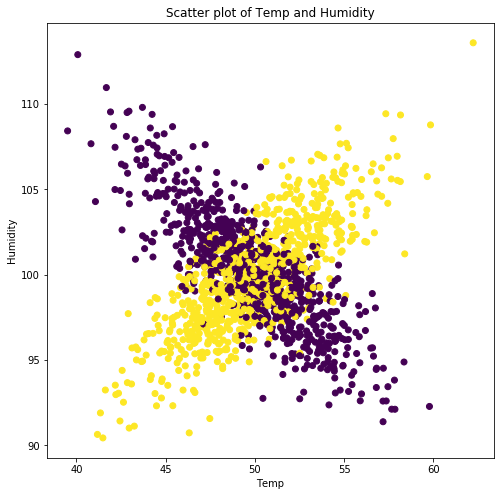

In [498]:
x = train_set[:, [0]]
y = train_set[:, [1]]
label = train_set[:, [2]]

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label)

plt.title('Scatter plot of Temp and Humidity')
plt.xlabel('Temp')
plt.ylabel('Humidity')
plt.show()

## Naive Model

I will Start with implementing the normal distribution probability density function in the next cell: 
$$ \frac{1}{\sqrt{2\pi \sigma^2}} \cdot e ^{-\frac{(x - \mu)^2}{2\sigma^2}} $$
Where :
* $\mu$ is the distribution mean.
* $\sigma$ is the distribution standard deviation.

Recall that I'm using naive assumption and assume the features are indepenent given the class. Meaning:
$$ P(x_1, x_2 | Y) = p(x_1 | Y) \cdot p(x_2 | Y)$$


Since I assume the features are normally distributed I will find the mean and std for each feature in order to compute those probabilites.

In [499]:
train_set

array([[ 47.98973623,  98.51433514,   1.        ],
       [ 50.1022401 ,  98.42873114,   1.        ],
       [ 48.40414682, 102.34762778,   0.        ],
       ...,
       [ 52.60810327, 104.58261091,   1.        ],
       [ 48.58095862, 100.86012444,   0.        ],
       [ 47.4947022 , 101.37022326,   0.        ]])

In [500]:
np.sum(a = train_set, axis = 0)

array([ 79812.73059552, 160089.49623617,    796.        ])

In [501]:
np.std(train_set[:, [0]])

3.2172262571296653

In [502]:
np.size(train_set, 0)

1600

In [503]:
class_df = train_set[(train_set[:, -1] == 0)][:, :-1]
np.mean(class_df, axis=0)

array([ 49.81710134, 100.2128793 ])

In [504]:
def normal_pdf(x, mean, std):
    """
    Calculate normal desnity function for a given x, mean and standrad deviation.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mean and var for the given x.    
    """
    return (1 / np.sqrt(2 * np.pi * std * std)) * pow(np.e, -1 * ((x - mean) * (x - mean))/(2 * std * std))

class NaiveNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulate the relevant parameters(mean, std) for a class conditinoal normal distribution.
        The mean and std are computed from a given data set.
        
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        
        class_filter = dataset[(dataset[:, -1] == class_value)][:, :-1]
        self.class_count = len(class_filter)
        self.total_count = len(dataset)
        self.mean = np.mean(class_filter, axis=0)
        self.std = np.std(class_filter, axis=0)
        
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.class_count / self.total_count
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihhod porbability of the instance under the class according to the dataset distribution.
        """
        return np.prod(normal_pdf(x, self.mean, self.std))
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x) * self.get_prior()

In [505]:
# Build the a NaiveNormalClassDistribution for each class.
naive_normal_CD_0 = NaiveNormalClassDistribution(train_set, 0)
naive_normal_CD_1 = NaiveNormalClassDistribution(train_set, 1)

In [506]:
naive_normal_CD_0.mean

array([ 49.81710134, 100.2128793 ])

In [507]:
naive_normal_CD_0.std

array([3.24301965, 3.31688992])

In [508]:
naive_normal_CD_0.get_instance_posterior(5)

2.9530533681049885e-223

Implementing the MAPClassifier class and build a MAPClassifier object contating the 2 distribution objects.

In [509]:
class MAPClassifier():
    def __init__(self, ccd0 , ccd1):
        """
        A Maximum a postreiori classifier. 
        This class will hold 2 class distributions, one for class 0 and one for class 1, and will predicit an instance
        by the class that outputs the highest posterior probability for the given instance.
    
        Input
            - ccd0 : An object contating the relevant parameters and methods for the distribution of class 0.
            - ccd1 : An object contating the relevant parameters and methods for the distribution of class 1.
        """
        self.ccd0 = ccd0
        self.ccd1 = ccd1
        
    def predict(self, x):
        """
        Predicts the instance class using the 2 distribution objects given in the object constructor.
    
        Input
            - An instance to predict.
        Output
            - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        """
        if self.ccd0.get_instance_posterior(x) > self.ccd1.get_instance_posterior(x):
              return 0
        else:
              return 1

In [510]:
naive_normal_classifier = MAPClassifier(naive_normal_CD_0, naive_normal_CD_1)

### Evaluate model
I will implement the compute_accuracy function. I will use it and the 2 distribution objects I created to compute the accuracy on the test set.

In [511]:
def compute_accuracy(testset, map_classifier):
    """
    Compute the accuracy of a given a testset using a MAP classifier object.
    
    Input
        - testset: The testset for which to compute the accuracy (Numpy array).
        - map_classifier : A MAPClassifier object capable of prediciting the class for each instance in the testset.
        
    Ouput
        - Accuracy = #Correctly Classified / #testset size
    """
     
    count = 0
    temp_hum = testset[:,:-1]
    labels = testset[:,-1]
    for i in range(temp_hum.shape[0]):
        x = temp_hum[i, :]
        label = labels[i]
        prediction = map_classifier.predict(x)
        if prediction == label:
              count += 1
    return count / testset.shape[0]

In [512]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
naive_accuracy = compute_accuracy(test_set, naive_normal_classifier)
naive_accuracy

0.495

## Full Model

I will start with Implementing the multivariate normal distribution probability density function.

## $$ (2\pi)^{-\frac{d}{2}} det(\Sigma )^{-\frac{1}{2}} \cdot e ^{-\frac{1}{2}(x-\mu)^T \Sigma ^ {-1} (x - \mu) }$$

Where : 
* $\mu$ is the distribution mean vector. (length 2 in our case)
* $\Sigma$ Is the distribution covarince matrix. (size 2x2 in our case)

In [513]:
x = train_set[:, :-1]
np.mean(x, axis=0)

array([ 49.88295662, 100.05593515])

In the full bayes model I will not make any simplyfing assumptions, meaning, I will use a multivariate normal distribution. <br>
And so, compute the mean of each feature and to compute the covariance between the features to build the covariance matrix.

In [514]:
def multi_normal_pdf(x, mean, cov):
    """
    Calculate multi variable normal desnity function for a given x, mean and covarince matrix.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mean and var for the given x.    
    """
    return pow(2 * np.pi, -1) * pow(np.linalg.det(cov), -1/2) * pow(np.e, -1/2 * np.dot(np.dot(np.matrix.transpose(x - mean), np.linalg.inv(cov)), (x - mean))) 
    
class MultiNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulate the relevant parameters(mean, cov matrix) for a class conditinoal multi normal distribution.
        The mean and cov matrix (You can use np.cov for this!) will be computed from a given data set.
        
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        class_filter = dataset[(dataset[:, -1] == class_value)][:, :-1]
        self.transpose_class = np.matrix.transpose(class_filter)
        self.cov_matrix = np.cov(self.transpose_class)
        self.class_count = len(class_filter)
        self.total_count = len(dataset)
        self.mean = np.mean(class_filter, axis=0)
                                                                                   
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.class_count / self.total_count 
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        return np.prod(multi_normal_pdf(x, self.mean, self.cov_matrix))
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x) * self.get_prior()

In [515]:
# Build the a MultiNormalClassDistribution for each class.
multi_normal_CD_0 = MultiNormalClassDistribution(train_set, 0)
multi_normal_CD_1 = MultiNormalClassDistribution(train_set, 1)

In [516]:
multi_normal_CD_0.mean

array([ 49.81710134, 100.2128793 ])

In [517]:
multi_normal_CD_0.cov_matrix

array([[10.53027379, -8.91435023],
       [-8.91435023, 11.01545959]])

In [518]:
#multi_normal_CD_0.get_instance_likelihood()

I will build a MAPClassifier object contating the 2 distribution objects I just made above.

In [519]:
multi_normal_classifier = MAPClassifier(multi_normal_CD_0, multi_normal_CD_1)

### Evaluate model
I will use the compute_accuracy function and the 2 distribution objects I created to compute the accuracy on the test set.

In [520]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
full_accuracy = compute_accuracy(test_set, multi_normal_classifier)
full_accuracy

0.7975

## Results

Text(0, 0.5, 'Accuracy')

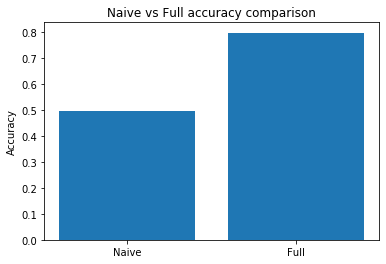

In [521]:
# Bar plot of accuracy of each model side by side.
plt.bar(x=['Naive', 'Full'], height=[naive_accuracy, full_accuracy])
plt.title("Naive vs Full accuracy comparison")
plt.ylabel("Accuracy")

# Discrete Naive Bayes Classifier 

Now I will build a discrete naive Bayes based classifier using **Laplace** smoothing.

$$ P(x_j | A_i) = \frac{n_{ij} + 1}{n_i + |V_j|} $$
Where:
* $n_{ij}$ The number of training instances with the class $A_i$ and the value $x_j$ in the relevant attribute.
* $n_i$ The number of training instances with the class $A_i$
* $|V_j|$ The number of possible values of the relevant attribute.

In order to compute the likelihood I assume:
$$ P(x| A_i) = \prod\limits_{j=1}^{n}P(x_j|A_i) $$

And to classify an instance I will choose : 
$$\arg\!\max\limits_{i} P(A_i) \cdot P(x | A_i)$$


## Data
I will try to predict breast cancer again only this time from a different dataset.
 

In [522]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
train_set = pd.read_csv('data/breast_trainset.csv').values
test_set = pd.read_csv('data/breast_testset.csv').values

## Build A Discrete Naive Bayes Distribution for each class
Implement the **DiscreteNBClassDistribution** in the next cell and build a distribution object for each class.

In [523]:
EPSILLON = 1e-6 # if a certain value only occurs in the test set, the probability for that value will be EPSILLON.

class DiscreteNBClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which computes and encapsulate the relevant probabilites for a discrete naive bayes 
        distribution for a specific class. The probabilites are computed with laplace smoothing.
        
        Input
        - dataset: The dataset as a numpy array.
        - class_value: Compute the relevant parameters only for instances from the given class.
        """
        self.dataset = dataset
        self.data_class = dataset[dataset[:, dataset.shape[1] - 1]==class_value, : -1]
    
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        return self.data_class.shape[0]/self.dataset.shape[0]
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        likelihood = 1
        n_i = self.data_class.shape[0]
        for j in range(x.shape[0]):
            vals, v_counts = np.unique(self.data_class[:, j], return_counts=True)
            v_j = vals.shape[0]
            val = x[j]
            if val in vals:
                n_ij = v_counts[np.where(vals == val)]
                likelihood *= (n_ij + 1) / (n_i + v_j) 
            else:
                likelihood *= EPSILLON

        return likelihood
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x) * self.get_prior()

In [491]:
discrete_naive_CD_0 = DiscreteNBClassDistribution(train_set, 0)
discrete_naive_CD_1 = DiscreteNBClassDistribution(train_set, 1)

I will build a MAPClassifier object contating the 2 distribution objects I just made above.

In [492]:
discrete_naive_classifier = MAPClassifier(discrete_naive_CD_0, discrete_naive_CD_1)

I will Use the **compute_accuracy** function and the 2 distribution objects I created to compute the accuracy on the test set.

In [493]:
compute_accuracy(test_set, discrete_naive_classifier)

0.7368421052631579